In [170]:
import numpy as np
import matplotlib.pyplot as plt

In [171]:
from numpy import genfromtxt
my_data = genfromtxt('dataA.csv', delimiter=',')

Text(0, 0.5, '$x_1$')

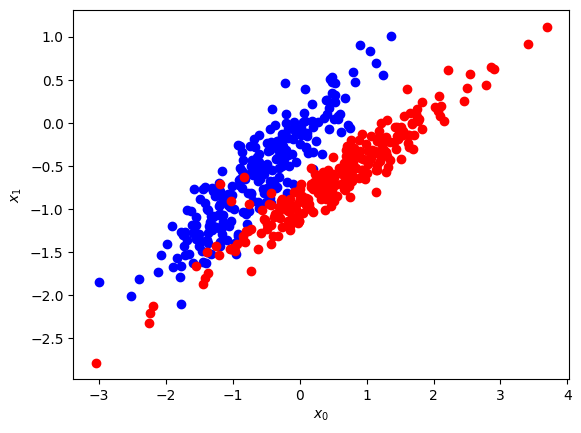

In [172]:
sig_mask = my_data[:, 2] == 1
noise_mask = my_data[:, 2] == 0
plt.scatter(my_data[noise_mask][:, 0], my_data[:, 1][noise_mask], color='blue')
plt.scatter(my_data[sig_mask][:, 0], my_data[:, 1][sig_mask], color='red')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')

In [173]:

def my_tree(data):
    my_label = np.zeros(len(data))
    for i in range(0,len(data)):
        if data[i, 1] < -1:
            if data[i, 0] <0.5:
                my_label[i] += 1
        elif data[i, 1] >= -1:
            if data[i, 0] >= 0.5:
                my_label[i] += 1
    return my_label

# or, in a more pythonic way:
def my_tree(data):
    return np.array([1 if x[1] < -1 and x[0] < 0.5 or x[1] >= -1 and x[0] >= 0.5 else 0 for x in data])

In [174]:
my_label = my_tree(my_data)

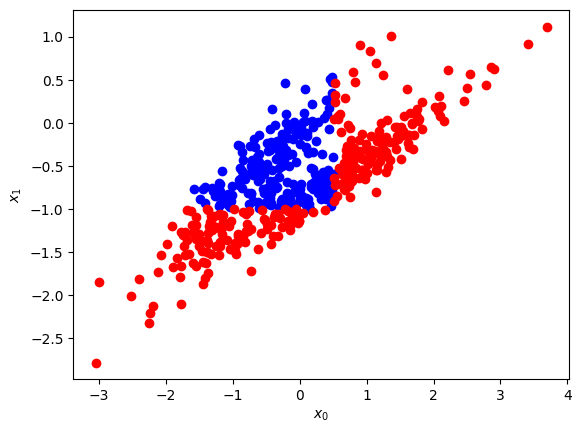

In [175]:
# plot the decision boundary on top of the data
plt.scatter(my_data[my_label == 0][:, 0], my_data[:, 1][my_label == 0], color='blue')
plt.scatter(my_data[my_label == 1][:, 0], my_data[:, 1][my_label == 1], color='red')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.show()

In [176]:
sig_eff = my_label[sig_mask].sum()/sig_mask.sum()
print(sig_eff)
bkg_rej = (1 - my_label[noise_mask].sum()/noise_mask.sum())
print(bkg_rej)

0.7283464566929134
0.6260162601626016


In [177]:
# mean vectors of classes
mean_sig = np.mean(my_data[sig_mask], axis=0)
mean_bkg = np.mean(my_data[noise_mask], axis=0)
# pretty print with names and rounding
print('Mean signal:', ['%.2f' % x for x in mean_sig])
print('Mean background:', ['%.2f' % x for x in mean_bkg])

Mean signal: ['0.53', '-0.64', '1.00']
Mean background: ['-0.65', '-0.64', '0.00']


In [178]:
# whithin class scatter
S_w = np.cov(my_data[sig_mask][:, :2].T) + np.cov(my_data[noise_mask][:, :2].T)
print(S_w)

# pretty print with names and rounding
print('Within-class scatter:', ['%.2f' % x for x in S_w.flatten()])

[[1.54801128 0.91410372]
 [0.91410372 0.65034977]]
Within-class scatter: ['1.55', '0.91', '0.91', '0.65']


In [179]:
# fisher discriminant vector
inv_S_w = np.linalg.inv(S_w)
w = inv_S_w.dot(mean_sig[:2] - mean_bkg[:2])
# pretty print with names and rounding
print('Fisher discriminant vector:', ['%.3f' % x for x in w])

Fisher discriminant vector: ['4.500', '-6.327']


In [180]:
# a brief dash of linear algebra in python/numpy
y_f = np.sum((w)*my_data[:, :2], axis=1)
# or, in a more pythonic way
y_f = np.dot(my_data[:, :2], w)
# or, with einstein summation
y_f = np.einsum('ij,j->i', my_data[:, :2], w)
# but also, with the @ operator
y_f = my_data[:, :2] @ w
# or, with np.matmul
y_f = np.matmul(my_data[:, :2], w)

In [181]:
print(y_f.shape)

(500,)


[]

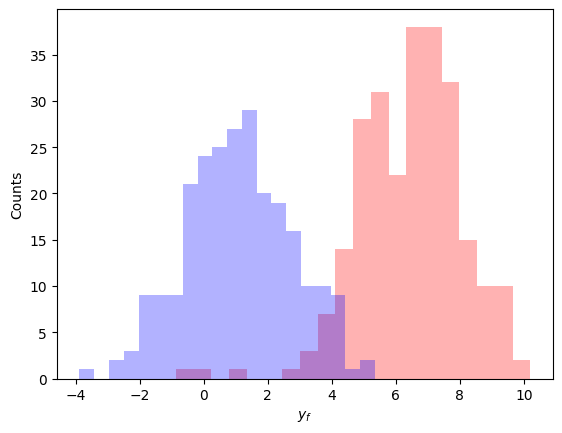

In [182]:
plt.hist(y_f[sig_mask], bins=20, color='red', alpha=0.3)
plt.hist(y_f[noise_mask], color='blue', bins=20, alpha=0.3)
plt.xlabel(r'$y_f$')
plt.ylabel('Counts')
plt.plot()


(-2.0, 1.0)

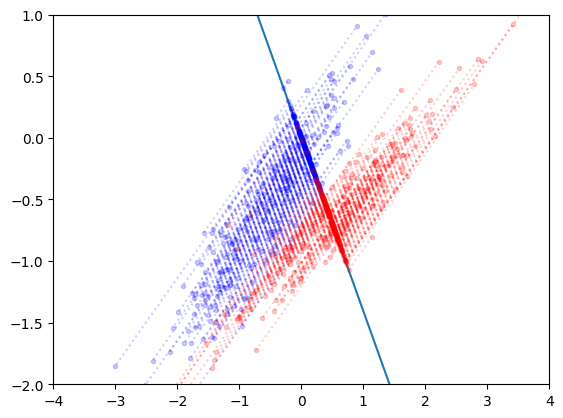

In [183]:
# here we plot the fisher vector with the points collapsing to the fisher axis
plt.plot([-w[0], w[0]], [-w[1], w[1]]) # this is the solution

# let's project data point on it
r = w.reshape(2,)
n2 = np.linalg.norm(r)**2
for pt in my_data[noise_mask][:, :2]:
    prj = r * r.dot(pt) / n2
    plt.plot([prj[0], pt[0]], [prj[1], pt[1]], 'b.:', alpha=0.2)
for pt in my_data[sig_mask][:, :2]:
    prj = r * r.dot(pt) / n2
    plt.plot([prj[0], pt[0]], [prj[1], pt[1]], 'r.:', alpha=0.2)
    
# set limits on x and y axis
plt.xlim(-4, 4)
plt.ylim(-2, 1.0)

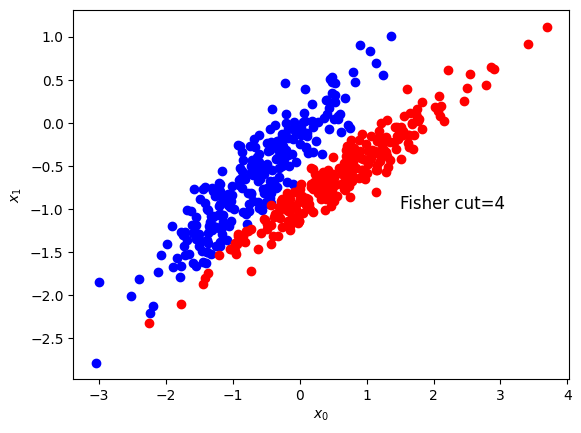

0.9488188976377953
0.9634146341463414


In [184]:
fisher_cut = 4
my_label = y_f >= fisher_cut

# plot the decision boundary on top of the data
plt.scatter(my_data[:, 0][my_label == 0], my_data[:, 1][my_label == 0], color='blue')
plt.scatter(my_data[:, 0][my_label == 1], my_data[:, 1][my_label == 1], color='red')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.text(1.5, -1, f'Fisher cut={fisher_cut}', color='black', fontsize=12)
plt.show()


sig_eff = my_label[sig_mask].sum()/sig_mask.sum()
print(sig_eff)
bkg_rej = (1 - my_label[noise_mask].sum()/noise_mask.sum())
print(bkg_rej)

In [185]:
def fisher_discriminant(data, sig_mask, bkg_mask):
    # mean vectors of classes
    mean_sig = np.mean(data[sig_mask], axis=0)
    mean_bkg = np.mean(data[bkg_mask], axis=0)
    S_w = np.cov(data[sig_mask][:, :2].T) + np.cov(data[bkg_mask][:, :2].T)
    print(S_w.shape)
    print(S_w)
    print(mean_sig.shape)
    print(mean_bkg.shape)
    inv_S_w = np.linalg.inv(S_w)
    # assume data is 2d
    w = inv_S_w.dot(mean_sig[:2] - mean_bkg[:2])
    print(w.shape)
    
    return data[:, :2] @ w, w

Text(0, 0.5, '$x_1$')

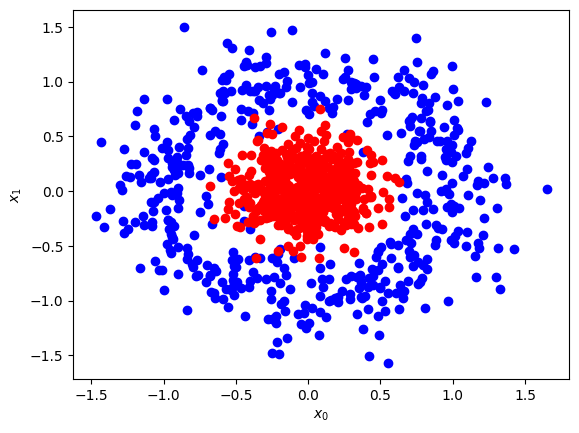

In [186]:
new_data = genfromtxt('dataB.csv', delimiter=',')[1:]
sig_mask = new_data[:, 2] == 1
noise_mask = new_data[:, 2] == 0
plt.scatter(new_data[noise_mask][:, 0], new_data[:, 1][noise_mask], color='blue')
plt.scatter(new_data[sig_mask][:, 0], new_data[:, 1][sig_mask], color='red')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')

(2, 2)
[[ 0.61421976 -0.00422368]
 [-0.00422368  0.60865041]]
(3,)
(3,)
(2,)


[]

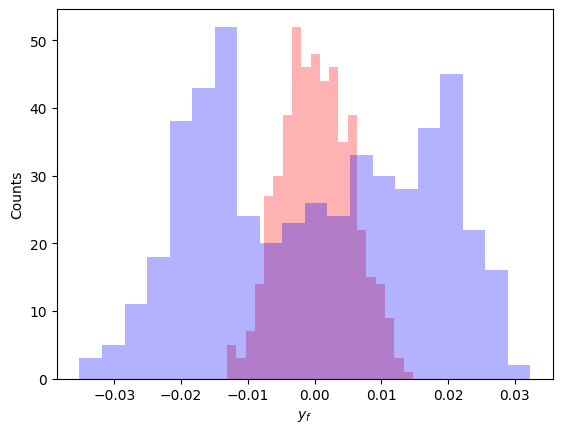

In [187]:
y_f_new, _ = fisher_discriminant(new_data, sig_mask, noise_mask)

plt.hist(y_f_new[sig_mask], bins=20, color='red', alpha=0.3)
plt.hist(y_f_new[noise_mask], color='blue', bins=20, alpha=0.3)
plt.xlabel(r'$y_f$')
plt.ylabel('Counts')
plt.plot()

In [188]:
def convert_to_polar(X):
    """ X has 2 dims"""
    r = np.sqrt(X[:,0]**2 + X[:,1]**2)
    theta = np.arctan2(X[:,1], X[:,0])
    return np.stack((r, theta), axis=1)

new_data = convert_to_polar(new_data)

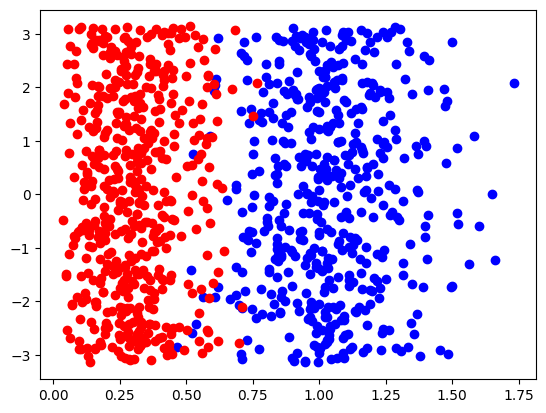

In [189]:
plt.scatter(new_data[noise_mask][:, 0], new_data[:, 1][noise_mask], color='blue')
plt.scatter(new_data[sig_mask][:, 0], new_data[:, 1][sig_mask], color='red')

(2, 2)
[[0.06333875 0.02527996]
 [0.02527996 6.76651759]]
(2,)
(2,)
(2,)


[]

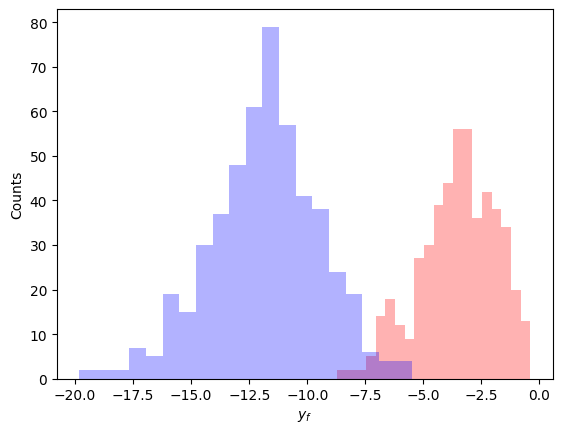

In [190]:
y_f_new, w = fisher_discriminant(new_data, sig_mask, noise_mask)

plt.hist(y_f_new[sig_mask], bins=20, color='red', alpha=0.3)
plt.hist(y_f_new[noise_mask], color='blue', bins=20, alpha=0.3)
plt.xlabel(r'$y_f$')
plt.ylabel('Counts')
plt.plot()

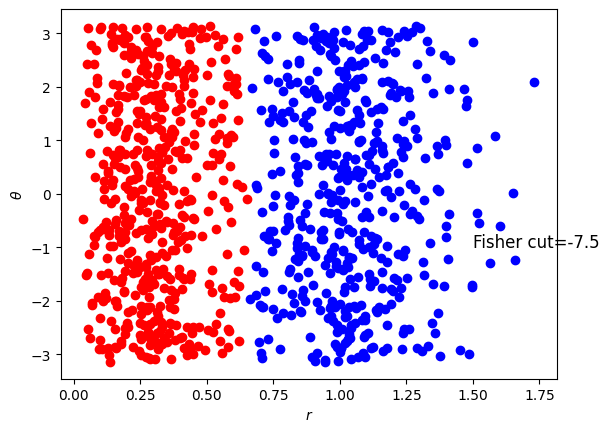

In [191]:
y_cut = -7.5
my_label = y_f_new >= y_cut

# plot the decision boundary on top of the data
plt.scatter(new_data[my_label == 0][:, 0], new_data[:, 1][my_label == 0], color='blue')
plt.scatter(new_data[my_label == 1][:, 0], new_data[:, 1][my_label == 1], color='red')
plt.xlabel(r'$r$')
plt.ylabel(r'$\theta$')
plt.text(1.5, -1, f'Fisher cut={y_cut}', color='black', fontsize=12)
plt.show()


In [192]:
def my_fisher_discriminant(data, sig_mask, bkg_mask):
    # mean vectors of classes
    mean_sig = np.mean(data[sig_mask], axis=0)
    mean_bkg = np.mean(data[bkg_mask], axis=0)
    S_w = np.cov(data[sig_mask][:, :2].T) + np.cov(data[bkg_mask][:, :2].T)
    print(S_w.shape)
    print(S_w)
    print(mean_sig.shape)
    print(mean_bkg.shape)
    inv_S_w = np.linalg.inv(S_w)
    # assume data is 2d
    w = inv_S_w.dot(mean_sig[:2] - mean_bkg[:2])
    print(w.shape)
    
    return data[:, :2] @ w, w

(2, 2)
[[ 2.32977358 -1.45214635]
 [-1.45214635  1.16811832]]
(3,)
(3,)
(2,)
(500,) [ 9.64776631e-01  1.71757474e+00  3.76694702e+01  1.96126124e+00
  5.09471973e-01  1.06802146e+00  5.77615297e+00  2.96207416e+00
  2.25967148e+00  4.91748275e+00  3.13387923e+01  3.18998047e+01
  4.95118302e+00  1.78791107e+00  4.07479773e+00  4.57400504e+00
  3.44835821e+01  2.74750891e+01  1.23335304e-01  1.48542220e+00
  2.81878127e+00  3.77391756e+00  7.62201326e+00  2.33765862e+00
  3.50983432e+01  4.28679083e+00  1.25154390e+00  3.47284907e+01
  4.97796937e+00  3.43619234e+00  2.80296967e+01  3.40630489e+01
  2.69702218e+01  3.51305708e+01  3.02624372e+01  3.10480405e+01
  2.73643831e+01  3.71566801e+01  4.68114421e+00  3.21922121e+01
  3.40333834e+01 -6.17166563e-01  2.18792434e+00  3.71592846e+01
  3.78118896e+00  2.58846339e+00  4.39352456e+00  2.97110042e+01
  2.77452786e+00  3.41427050e+01  3.26010040e+01  1.80293352e+00
  3.49602107e+01  4.12658128e+00  3.52259283e+01  4.92867591e-01
  4.56

(array([  2.,   5.,  55., 104.,  69.,  14.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,   1.]),
 array([-3.9227586 , -1.87942311,  0.16391239,  2.20724789,  4.25058339,
         6.29391889,  8.33725438, 10.38058988, 12.42392538, 14.46726088,
        16.51059638, 18.55393187, 20.59726737, 22.64060287, 24.68393837,
        26.72727387, 28.77060936, 30.81394486, 32.85728036, 34.90061586,
        36.94395136]),
 <BarContainer object of 20 artists>)

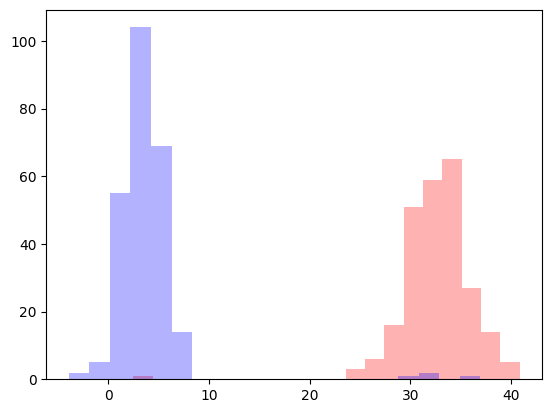

In [193]:
# try it on new_data.csv
new_data = genfromtxt('new_data1.csv', delimiter=',')[1:]
sig_mask = new_data[:, 2] == 1
noise_mask = new_data[:, 2] == 0
# new_data = convert_to_polar(new_data)
y_f_new, w = my_fisher_discriminant(new_data, sig_mask, noise_mask)
print(y_f_new.shape, y_f_new)
plt.hist(y_f_new[sig_mask], bins=20, color='red', alpha=0.3)
plt.hist(y_f_new[noise_mask], color='blue', bins=20, alpha=0.3)

(-1.0, 5.0)

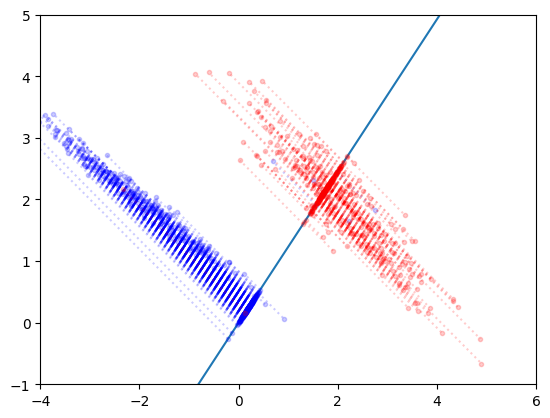

In [196]:
# here we plot the fisher vector with the points collapsing to the fisher axis
plt.plot([-w[0], w[0]], [-w[1], w[1]]) # this is the solution

# let's project data point on it
r = w.reshape(2,)
n2 = np.linalg.norm(r)**2
for pt in new_data[noise_mask][:, :2]:
    prj = r * r.dot(pt) / n2
    plt.plot([prj[0], pt[0]], [prj[1], pt[1]], 'b.:', alpha=0.2)
for pt in new_data[sig_mask][:, :2]:
    prj = r * r.dot(pt) / n2
    plt.plot([prj[0], pt[0]], [prj[1], pt[1]], 'r.:', alpha=0.2)
    
plt.xlim(-4, 6)
plt.ylim(-1, 5)

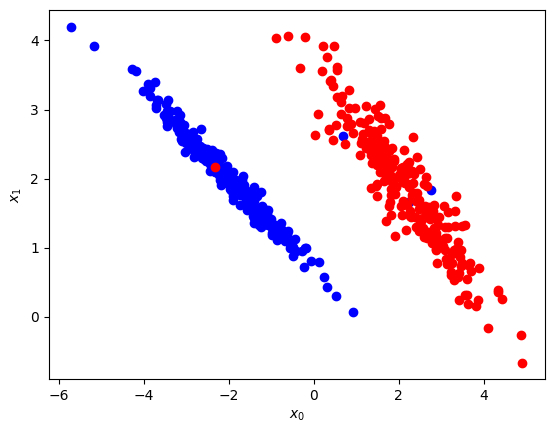

Text(1.5, -1, 'Fisher cut=20')

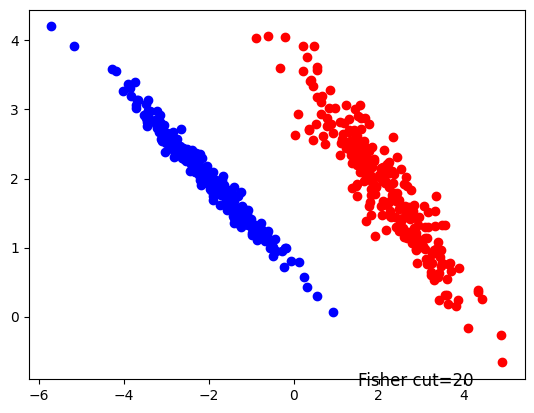

In [195]:
# plot the orginal data with the original labels
plt.scatter(new_data[noise_mask][:, 0], new_data[:, 1][noise_mask], color='blue')
plt.scatter(new_data[sig_mask][:, 0], new_data[:, 1][sig_mask], color='red')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.show()

y_cut = 20
my_label = y_f_new >= y_cut

# plot the decision boundary on top of the data
plt.scatter(new_data[my_label == 0][:, 0], new_data[:, 1][my_label == 0], color='blue')
plt.scatter(new_data[my_label == 1][:, 0], new_data[:, 1][my_label == 1], color='red')
plt.text(1.5, -1, f'Fisher cut={y_cut}', color='black', fontsize=12)